In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
file_path = "predictive_maintenance.csv"  # Update with your file path
df = pd.read_csv(file_path)

# Drop unnecessary columns
df = df.drop(["UDI"], axis=1)

# Encode categorical variables
label_encoder = LabelEncoder()
df["Product ID"] = label_encoder.fit_transform(df["Product ID"])
df["Type"] = label_encoder.fit_transform(df["Type"])
df["Failure Type"] = label_encoder.fit_transform(df["Failure Type"])

# Split data into features (X) and target (y)
X = df.drop(["Target"], axis=1)
y = df["Target"]

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


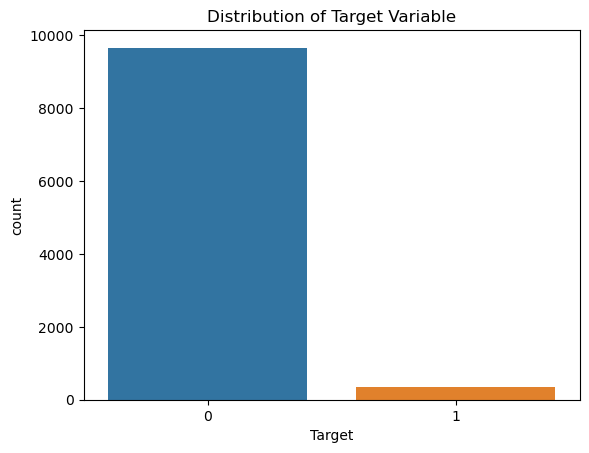

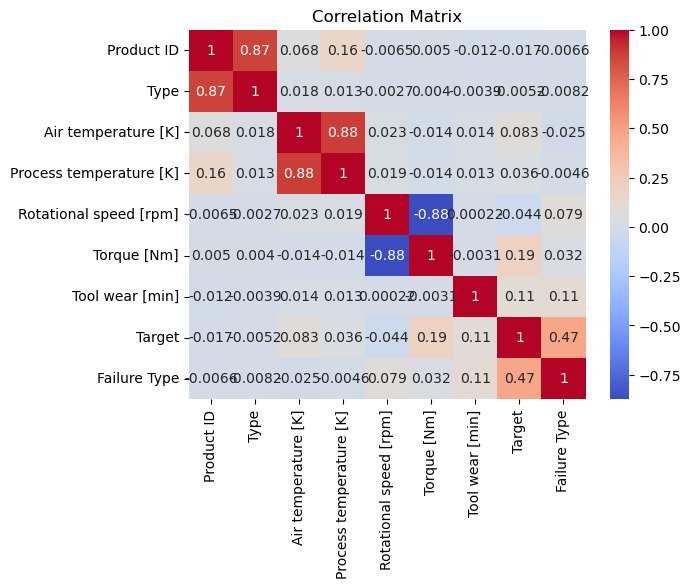

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable
sns.countplot(x="Target", data=df)
plt.title("Distribution of Target Variable")
plt.show()

# Visualize correlations between numerical features
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import accuracy_score

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.LongTensor(np.array(y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].squeeze() 

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, len(df["Target"].unique()))

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create dataset and dataloaders
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


In [57]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Initialize the model, criterion, and optimizer
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)


In [69]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
    return loss.item()

# Evaluate on the test set
test_loss = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss}')


Test Loss: 0.10217797011137009


In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, lr=0.01, epochs=100):
        self.input_size = input_size
        self.lr = lr
        self.epochs = epochs
        self.model = NeuralNetwork(input_size)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        
        # Convert X and y to PyTorch tensors
        train_dataset = MyDataset(X, y)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

    def predict(self, X):
        check_is_fitted(self, ['classes_'])
        X = check_array(X)
        
        # Convert X to a PyTorch tensor
        test_dataset = MyDataset(X, [0] * len(X))
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

        predictions = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.numpy())

        return np.array(predictions)

# Define hyperparameter grid
param_grid = {
    'lr': [0.001, 0.01],
    'epochs': [10, 20]
}

classifier = PyTorchClassifier(input_size)
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Train the model with the best hyperparameters
best_classifier = grid_search.best_estimator_
best_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_classifier.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy}')

# Print other metrics like classification report, sensitivity, f1 score, etc.
print(classification_report(y_test, y_pred))


TypeError: 'Adam' object is not callable

In [60]:
# Example of plotting training loss over epochs
import matplotlib.pyplot as plt

def plot_training_results(history):
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example of using early stopping
from sklearn.base import clone
from sklearn.metrics import accuracy_score

def early_stopping(model, X_train, y_train, X_val, y_val, patience=5,epochs=20):
    best_model = None
    best_loss = float('inf')
    current_patience = 0

    train_dataset = MyDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = MyDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = evaluate_model(model, val_loader, criterion)

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss}')

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = clone(model)
            current_patience = 0
        else:
            current_patience += 1
            if current_patience == patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    return best_model, history

# Example usage of early stopping
model = NeuralNetwork(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_model, history = early_stopping(model, X_train, y_train, X_test, y_test, patience=5,epochs=20)

# Plot training and validation loss
plot_training_results(history)


Epoch 1/20, Train Loss: 0.045574937015771866, Val Loss: 0.10217797011137009


TypeError: Cannot clone object 'NeuralNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)' (type <class '__main__.NeuralNetwork'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [81]:
sec= pd.read_csv('regression/securities.csv', index_col='Ticker symbol').sort_index()
sec = sec.drop(['SEC filings','Date first added'], axis=1)
sec.head()

,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,CIK
Ticker symbol,,,,,
YHOO,Yahoo Inc.,Information Technology,Internet Software & Services,"Sunnyvale, California",1011006
YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1041061
ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment,"Warsaw, Indiana",1136869
ZION,Zions Bancorp,Financials,Regional Banks,"Salt Lake City, Utah",109380
ZTS,Zoetis,Health Care,Pharmaceuticals,"Florham Park, New Jersey",1555280


In [84]:
adj_price = pd.read_csv('regression/prices-split-adjusted.csv').sort_values(by=['date','symbol'], ascending=[True,True])
adj_price.tail()

,date,symbol,open,close,low,high,volume
851257,2016-12-30,YHOO,38.720001,38.669998,38.430000,39.000000,6431600.0
851258,2016-12-30,YUM,63.930000,63.330002,63.160000,63.939999,1887100.0
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
